# Import

In [4]:
# 기본 세팅
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import gaussian_kde
from matplotlib import colors as mpl_colors
import os
import argparse
from datetime import datetime
from glob import glob
from itertools import product, groupby
from mpl_toolkits.mplot3d import Axes3D
import re

# Font & Color

##### TODO
- font download

In [20]:
# font = {'family': 'Tahoma'}
# font = {'family': 'Times New Roman'}

# plt.rc('font', **font)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
colors_fill = [None, "#54637C", "#587C86", "#5D928B","#65A68D", 
               "#71B88E", "#83C98F", "#9CD790", "#BBE394", 
               "#D9ED9D", "#F1F4B0", "#FEFAD3"]
grid_color = 'gainsboro'

In [6]:
def layerNum(model:str) -> int:
    if model == "densenet201" :
        return 306
    elif model == "resnet152" :
        return 206
    elif model == "enetb0" :
        return 136
    elif model == "csmobilenet-v2" :
        return 81
    elif model == "squeezenet" :
        return 50
    elif model == "yolov7" :
        return 143
    elif model == "yolov7-tiny" :
        return 99
    elif model == "yolov4" :
        return 162
    elif model == "yolov4-tiny" :
        return 38
    elif model == "resnet10" :
        return 17
    elif model == "yolov2-tiny" :
        return 16
    else :
        print("Unknown model: ", model)
        return 0

def maxCore(device:str) -> int:
    if device == "nano":
        return 4
    if device == "orin":
        return 10
    else:
        print("Unknown device: ", device)
        return 0

### Options

In [7]:
save_formats = ['png', 'pdf', 'svg']
devices = ['nano', 'orin']
types = ["toy_simul", "real_simul", "real_exp"]
models = ['densenet201', 'resnet152', 'enetb0', 'csmobilenet-v2', 'squeezenet', 'yolov7', 'yolov7-tiny', 'yolov4', 'yolov4-tiny', 'resnet10', 'yolov2-tiny']

device = 'nano'
type = "real_exp"
model = "densenet201"
date_label = "0106"

max_cores = maxCore(device)
if type not in types:
    print("Unknown type: ", type)
layer_num = layerNum(model)
if not os.path.exists(f"../../csv/{date_label}"):
    print(f"Invalid date: {date_label}")

In [8]:
for save_format in save_formats:
    directory_path = f'./{save_format}'
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"디렉터리 '{directory_path}' 생성 완료!")
    else:
        print(f"디렉터리 '{directory_path}'가 이미 존재합니다.")

디렉터리 './png' 생성 완료!
디렉터리 './pdf' 생성 완료!
디렉터리 './svg' 생성 완료!


### Load csv & Dataframe 생성

3. real_exp

In [16]:
base_path = f"../../csv/{date_label}/gpu_accel_0_M/{model}/"

# 데이터를 수집할 데이터프레임을 초기화
columns = ['glayer', 'throughput', 'frame_rate', 'execution_time', 'cycle_time', 
           'num_thread_data', 'num_thread', 'accel_gain', 'block_loss', 'max_delay', 'min_delay']
data_list = []

num_thread = max_cores
path = os.path.join(base_path, f"{num_thread}thread")
for filename in sorted(os.listdir(path)):
    if filename.endswith(".csv"):
            num_glayer = int(filename.split('_')[2].replace('.csv', ''))
            df = pd.read_csv(os.path.join(path, filename))
            task_num = len(df)
            start_preprocess_time = df["start_preprocess"].iloc[0]
            end_infer_time = df["end_postprocess"].iloc[-1]
            Throughput = task_num / (end_infer_time - start_preprocess_time) * 1000
            if(num_glayer == 0):
                infer_time_standard = df["e_infer"].mean() - df["waiting_gpu"].mean()
            acceleration_gain = infer_time_standard - (df["e_infer"].mean() - df["waiting_gpu"].mean())

            block_loss = df["waiting_gpu"].mean()
            max_delay = df["execution_time"].max()
            min_delay = df["execution_time"].min()
            avg_frame_rate = df["frame_rate"].mean()
            avg_execution_time = df["execution_time"].mean()
            avg_cycle_time = df["cycle_time"].mean()
            avg_num_thread_data = df["num_thread"].mean()
            
            # 데이터프레임에 데이터 추가
            data_list.append([num_glayer, Throughput, avg_frame_rate, avg_execution_time, 
                              avg_cycle_time, avg_num_thread_data, num_thread, acceleration_gain, 
                              block_loss, max_delay, min_delay])
# 데이터프레임 생성
data_df = pd.DataFrame(data_list, columns=columns)
data_df = data_df.pivot(index='glayer', columns='num_thread')

frame_rate_df = data_df['frame_rate']
execution_time_df = data_df['execution_time']
cycle_time_df = data_df['cycle_time']

# 파일 경로 설정
# frame_rate_file_path = './gpu-accel-GC_frame_rate_data.csv'
# execution_time_file_path = './gpu-accel-GC_execution_time_data.csv'
# cycle_time_file_path = './gpu-accel-GC_cycle_time_data.csv'

# # 파일 저장
# frame_rate_df.to_csv(frame_rate_file_path)
# execution_time_df.to_csv(execution_time_file_path)
# cycle_time_df.to_csv(cycle_time_file_path)

# print(frame_rate_file_path, execution_time_file_path, cycle_time_file_path)

### Max throughput 계산

In [17]:

# # 결과를 저장할 리스트 초기화
# max_values = []

# # 각 스레드 수에 대해 반복
# for num_thread in range(1, num_total_cores):
#     if num_thread in data_df['frame_rate'].columns:
#         # frame_rate의 최대값 찾기
#         max_throughput = data_df['throughput'][num_thread].max()
#         # 최대 frame_rate의 인덱스 찾기
#         max_index = data_df['throughput'][num_thread].idxmax()
#         # 해당 인덱스의 execution_time 가져오기
#         corresponding_execution_time = data_df['execution_time'][num_thread].loc[max_index]

#         # 결과 저장
#         max_values.append({
#             'num_thread': num_thread,
#             'glayer': max_index,
#             'max_throughput': max_throughput,
#             'execution_time_at_max_fr': corresponding_execution_time
#         })

# # 결과 출력
# print("Point for Max Frame rate")
# for result in max_values:
#     print(f"Threads: {result['num_thread']}, Glayers: {result['glayer']}, 
#           Max Throughput: {result['max_throughput']:.2f}, 
#           Execution Time: {result['execution_time_at_max_fr']:.2f}")

### 다음 thread의 throughput 넘는 지점 찾기

In [19]:
# # 결과를 저장할 리스트 초기화
# cross_points = []

# # 각 스레드 수와 그 다음 스레드 수 비교
# for num_thread in range(10, num_total_cores - 1):
#     current_thread_frame_rates = data_df['frame_rate'][num_thread]
#     next_thread_frame_rates = data_df['frame_rate'][num_thread + 1]
#     current_thread_execution_time = data_df['execution_time'][num_thread]
#     next_thread_execution_time = data_df['execution_time'][num_thread + 1]
    
#     # glayer를 순회하면서 현재 스레드의 frame_rate가 다음 스레드의 frame_rate를 넘는 첫 번째 지점 찾기
#     for glayer in current_thread_frame_rates.index:
#         if current_thread_frame_rates[glayer] >= next_thread_frame_rates[glayer]:
#             cross_points.append({
#                 'num_thread': num_thread,
#                 'glayer': glayer,
#                 'current_frame_rate': current_thread_frame_rates[glayer],
#                 'next_frame_rate': next_thread_frame_rates[glayer],
#                 'current_execution_time': current_thread_execution_time[glayer],
#                 'next_execution_time': next_thread_execution_time[glayer]
#             })
#             break  # 첫 번째 조건 충족 지점에서 루프 종료

# # 결과 출력
# for point in cross_points:
#     print(f"Thread {point['num_thread']} exceeds Thread {point['num_thread']+1} 
#           at Glayer {point['glayer']}:")
#     print(f"  Thread {point['num_thread']}: {point['current_frame_rate']:.2f} fps, 
#           Thread {point['num_thread']+1}: {point['next_frame_rate']:.2f} fps")
#     print(f"  Thread {point['num_thread']}: {point['current_execution_time']:.2f} ms, 
#           Thread {point['num_thread']+1}: {point['next_execution_time']:.2f} ms")

# Graph

### throughput & delay - glayer

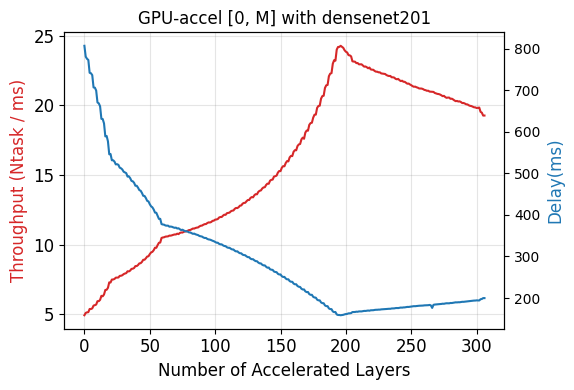

In [37]:
# Set up the plot
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))
ax2 = ax1.twinx()
colors = plt.cm.viridis(np.linspace(0, 1, 4))  # max_total_cores개의 색상을 viridis 컬러맵에서 선택
# 각 스레드에 대한 데이터 플롯
for num_thread in range(4, 5):
    color = colors[num_thread % len(colors)]
    color_fill = colors_fill[num_thread]
    if num_thread in data_df.columns.levels[1]:
        ax1.plot(data_df.index, data_df[('throughput', num_thread)], label=f"{num_thread} threads", color="tab:red", zorder = num_thread)
        ax2.plot(data_df.index, data_df[('execution_time', num_thread)], color="tab:blue", zorder = num_thread)
        # ax1.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)

        # if (num_thread == 1) or (num_thread == 2) or (num_thread == num_total_cores):
        #     ax2.plot(data_df.index, data_df[('num_thread_data', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index, data_df[('num_thread_data', num_thread)], color=color_fill, zorder=num_thread)
        # else:
        #     exceed_num = cross_points[num_thread - 3]['glayer']
        #     ax2.plot(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], color=color_fill, zorder=num_thread)

ax1.set_xlabel('Number of Accelerated Layers', size=12)

ax1.set_ylabel("Throughput (Ntask / ms)", size=12, color="tab:red")
ax2.set_ylabel("Delay(ms)", size = 12, color="tab:blue")

ax1.set_title(f"GPU-accel [0, M] with {model}", size=12)

ax1.tick_params(axis='both', labelsize=12)
plt.tight_layout()
ax1.grid(color='gray', alpha=0.2)
plt.show()


### accel gain & block loss - glayer

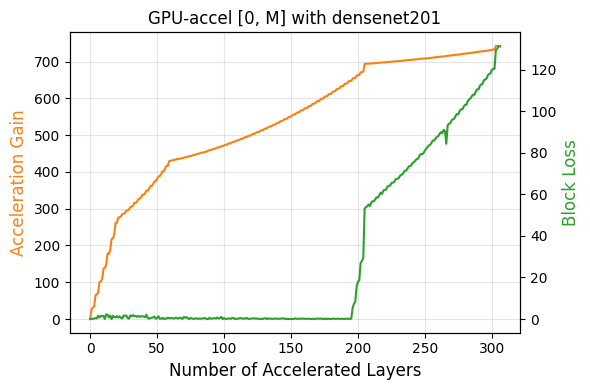

In [38]:
# Set up the plot
fig, (ax3) = plt.subplots(1, 1, figsize=(6, 4))
ax4 = ax3.twinx()
colors = plt.cm.viridis(np.linspace(0, 1, 4))  # max_total_cores개의 색상을 viridis 컬러맵에서 선택
# 각 스레드에 대한 데이터 플롯
for num_thread in range(4, 5):
    color = colors[num_thread % len(colors)]
    color_fill = colors_fill[num_thread]
    if num_thread in data_df.columns.levels[1]:
        ax3.plot(data_df.index, data_df[('accel_gain', num_thread)], color="tab:orange", zorder = num_thread)
        ax4.plot(data_df.index, data_df[('block_loss', num_thread)], color="tab:green", zorder = num_thread)
        # ax3.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)

ax3.set_xlabel('Number of Accelerated Layers', size=12)

ax3.set_ylabel("Acceleration Gain", size=12, color="tab:orange")
ax4.set_ylabel("Block Loss", size = 12, color="tab:green")

ax3.set_title(f"GPU-accel [0, M] with {model}", size=12)

plt.tight_layout()
ax3.grid(color='gray', alpha=0.2)
plt.show()


### net gain - glayer

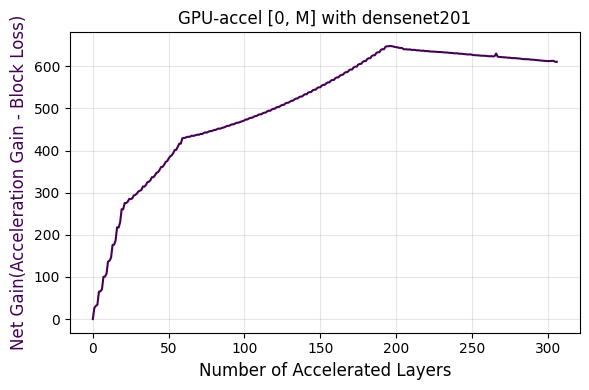

In [39]:
# Set up the plot
fig, (ax5) = plt.subplots(1, 1, figsize=(6, 4))
colors = plt.cm.viridis(np.linspace(0, 1, 4))  # max_total_cores개의 색상을 viridis 컬러맵에서 선택
# 각 스레드에 대한 데이터 플롯
for num_thread in range(4, 5):
    color = colors[num_thread % len(colors)]
    color_fill = colors_fill[num_thread]
    if num_thread in data_df.columns.levels[1]:
        ax5.plot(data_df.index, data_df[('accel_gain', num_thread)] - data_df[('block_loss', num_thread)], color=color, zorder = num_thread)
        # ax5.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)

ax5.set_xlabel('Number of Accelerated Layers', size=12)

ax5.set_ylabel("Net Gain(Acceleration Gain - Block Loss)", size = 12, color=color)

ax5.set_title(f"GPU-accel [0, M] with {model}", size=12)

plt.tight_layout()
ax5.grid(color='gray', alpha=0.2)
plt.show()


### 1-4thread
### throughput, delay, accel gain, block loss - glayer

In [ ]:
# # Set up the plot
# fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12, 8))

# colors = plt.cm.viridis(np.linspace(0, 1, num_total_cores))  # max_total_cores개의 색상을 viridis 컬러맵에서 선택
# # 각 스레드에 대한 데이터 플롯
# for num_thread in range(1, num_total_cores):
#     color = colors[num_thread % len(colors)]
#     color_fill = colors_fill[num_thread]
#     if num_thread in data_df.columns.levels[1]:
#         #ax1.plot(data_df.index, data_df[('frame_rate', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
#         ax1.plot(data_df.index, data_df[('throughput', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
#         ax2.plot(data_df.index, data_df[('execution_time', num_thread)], color=color, zorder = num_thread)
#         ax3.plot(data_df.index, data_df[('accel_gain', num_thread)], color=color, zorder = num_thread)
#         ax4.plot(data_df.index, data_df[('block_loss', num_thread)], color=color, zorder = num_thread)
#         ax1.axvline(x=max_values[num_thread - 1]['glayer'], color='red', zorder = num_thread, linestyle='--', alpha=0.3)
#         ax3.axvline(x=max_values[num_thread - 1]['glayer'], color='red', zorder = num_thread, linestyle='--', alpha=0.3)

#         # if (num_thread == 1) or (num_thread == 2) or (num_thread == num_total_cores):
#         #     ax2.plot(data_df.index, data_df[('num_thread_data', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
#         #     ax2.fill_between(data_df.index, data_df[('num_thread_data', num_thread)], color=color_fill, zorder=num_thread)
#         # else:
#         #     exceed_num = cross_points[num_thread - 3]['glayer']
#         #     ax2.plot(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], label=f"{num_thread} threads", color=color, zorder = num_thread)
#         #     ax2.fill_between(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], color=color_fill, zorder=num_thread)


# # ax1.set_xlabel('# of layer with GPU inference', size=20)
# # ax1.set_ylabel("Frame Rate (fps)", size=20)
# # ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4, frameon=False)

# ax1.set_ylabel("Throughput (tasks / ms)", size=20)
# ax2.set_ylabel("Delay Time (ms)", size = 20)
# ax3.set_ylabel("Accel Gain", size=20)
# ax4.set_ylabel("Block Loss", size = 20)
# ax1.set_xlabel('# of layer with GPU inference', size=20)
# ax3.set_xlabel('# of layer with GPU inference', size=20)
# ax2.set_xlabel('# of layer with GPU inference', size=20)
# ax4.set_xlabel('# of layer with GPU inference', size=20)
# # ax2.set_ylabel('Minimum # of thread', size=20)
# ax1.set_title("GPU-accel [0, M] with densenet201", size=20)
# ax1.tick_params(axis='both', labelsize=12)
# # ax2.tick_params(axis='both', labelsize=12)
# # ax3.tick_params(axis='both', labelsize=12)
# #ax1.legend(loc='lower center', bbox_to_anchor=(-0.3, 0.1), fontsize=6)
# #ax3.legend(loc='upper left', fontsize=3)
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=8)
# #plt.tight_layout()
# plt.show()
# #f"Thread {point['num_thread']} exceeds Thread {point['num_thread']+1} at Glayer {point['glayer']}:"
# print(f"Delay at Max Throughput: {data_df[('execution_time', 8)][np.nanargmax(data_df[('throughput', 8)])]}")
# print(f"Accel Gain at Max Throughput: {data_df[('accel_gain', 8)][np.nanargmax(data_df[('throughput', 8)])]}")
# print(f"Block Loss at Max Throughput: {data_df[('block_loss', 8)][np.nanargmax(data_df[('throughput', 8)])]}")
# print(f"Delay at Max last layer: {data_df[('execution_time', 8)].iloc[-1]}")
# print(f"Accel Gain at last layer: {data_df[('accel_gain', 8)].iloc[-1]}")
# print(f"Block Loss at last layer: {data_df[('block_loss', 8)].iloc[-1]}")
# print(f"Delay Gap: {data_df[('execution_time', 8)].iloc[-1] - data_df[('execution_time', 8)][np.nanargmax(data_df[('throughput', 8)])]}")
# print(f"Accel Gain Gap: {data_df[('accel_gain', 8)].iloc[-1] - data_df[('accel_gain', 8)][np.nanargmax(data_df[('throughput', 8)])]}")
# print(f"Block Loss Gap: {data_df[('block_loss', 8)].iloc[-1] - data_df[('block_loss', 8)][np.nanargmax(data_df[('throughput', 8)])]}")